In [1]:
!pip install tensorflow-addons --quiet

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ydata-profiling 4.6.4 requires typeguard<5,>=4.1.2, but you have typeguard 2.13.3 which is incompatible.


In [2]:
import random
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from keras.models import Model
from keras.layers import Input, Dense, concatenate, Dropout
from keras.optimizers import Adamax
from keras.callbacks import Callback
import keras.backend as K
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import Callback
import tensorflow_addons as tfa
from sklearn.metrics import roc_curve, auc
random.seed(54321)
############# Define function  ################ 

def pos_neg_acc(y_true,y_pred):
    positive_pred=y_pred[:,1]
    negative_pred=y_pred[:,0]
    diff=K.mean(K.cast(negative_pred<positive_pred,"float16"))
    return diff

def pos_neg_loss(y_true,y_pred):
    positive_pred=y_pred[:,1]
    negative_pred=y_pred[:,0]
    diff=K.mean(K.relu(1+negative_pred-positive_pred))+0.03*K.mean(K.square(negative_pred))
    return diff


class TestCallback(Callback):
    def __init__(self, test_data, test_labels):
        self.test_data = test_data
        self.test_labels = test_labels
        self.test_loss = []
        self.test_acc = []
        self.predictions = []

    def on_epoch_end(self, epoch, logs=None):
        loss, acc = self.model.evaluate(x=self.test_data, y=self.test_labels, verbose=0)
        predictions = self.model.predict(self.test_data)
        self.predictions.append(predictions)
        self.test_loss.append(loss)
        self.test_acc.append(acc)
        print(f'Testing loss: {loss}, acc: {acc}')

2024-06-19 05:50:34.653446: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-19 05:50:34.653581: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-19 05:50:34.792828: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
/opt/conda/lib/python3.10/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our Tens

In [3]:
############# Read training and testing data  ################
#train
tcr_file_train_pos='/kaggle/input/pmtnet-repeatfromissue/TCR_output_pos.csv'
tcr_file_train_neg='/kaggle/input/pmtnet-repeatfromissue/TCR_output_neg.csv'                                        
hla_antigen_file_train='/kaggle/input/pmtnet-repeatfromissue/MHC_antigen_output.csv'
tcr_train_pos=pd.read_csv(tcr_file_train_pos,index_col=0)
tcr_train_neg=pd.read_csv(tcr_file_train_neg,index_col=0)
hla_antigen_train=pd.read_csv(hla_antigen_file_train,index_col=0)
Y_train = np.random.randint(2, size=(2,tcr_train_pos.shape[0])).T
#test
test_data_pos = pd.read_csv('/kaggle/input/pmtnet-repeatfromissue/TCR_test_pos.csv', index_col=0)
test_data_pos = test_data_pos.loc[test_data_pos.index.repeat(10)].reset_index(drop=True)
test_data_neg = pd.read_csv('/kaggle/input/pmtnet-repeatfromissue/TCR_test_neg.csv', index_col=0)
test_hla_antigen = pd.read_csv('/kaggle/input/pmtnet-repeatfromissue/MHC_antigen_test.csv', index_col=0)
test_hla_antigen = test_hla_antigen.loc[test_hla_antigen.index.repeat(10)].reset_index(drop=True)
Y_test = np.random.randint(2, size=(2, test_data_pos.shape[0])).T 

In [4]:
##############network################

# 2 inputs:positive TCR and negative TCR
hla_antigen_in=Input(shape=(60,),name='hla_antigen_in')
pos_in=Input(shape=(30,),name='pos_in')
neg_in=Input(shape=(30,),name='neg_in')
    
ternary_layer1_pos=concatenate([pos_in,hla_antigen_in])
ternary_layer1_neg=concatenate([neg_in,hla_antigen_in])

ternary_dense1=Dense(300,activation='relu')
ternary_layer2_pos=ternary_dense1(ternary_layer1_pos)
ternary_layer2_neg=ternary_dense1(ternary_layer1_neg)

ternary_do1=Dropout(0.2)
ternary_layer3_pos=ternary_do1(ternary_layer2_pos)
ternary_layer3_neg=ternary_do1(ternary_layer2_neg)

ternary_dense2=Dense(150,activation='relu')
ternary_layer4_pos=ternary_dense2(ternary_layer3_pos)
ternary_layer4_neg=ternary_dense2(ternary_layer3_neg)

ternary_dense4=Dense(100,activation='sigmoid')
ternary_layer5_pos=ternary_dense4(ternary_layer4_pos)
ternary_layer5_neg=ternary_dense4(ternary_layer4_neg)

ternary_dense3=Dense(50,activation='relu')
ternary_layer6_pos=ternary_dense3(ternary_layer5_pos)
ternary_layer6_neg=ternary_dense3(ternary_layer5_neg)

ternary_output=Dense(1,activation='linear')
pos_out=ternary_output(ternary_layer6_pos)
neg_out=ternary_output(ternary_layer6_neg)
    
merged_vector=concatenate([neg_out,pos_out],axis=-1,name='output')

ternary_prediction=Model(inputs=[pos_in,neg_in,hla_antigen_in],outputs=merged_vector)

In [5]:
class WarmUpScheduler(tf.keras.callbacks.Callback):
    def __init__(self, warmup_epochs, initial_lr, final_lr):
        super(WarmUpScheduler, self).__init__()
        self.warmup_epochs = warmup_epochs
        self.initial_lr = initial_lr
        self.final_lr = final_lr
        self.step_size = (final_lr - initial_lr) / warmup_epochs

    def on_epoch_begin(self, epoch, logs=None):
        if epoch < self.warmup_epochs:
            new_lr = self.initial_lr + self.step_size * epoch
            tf.keras.backend.set_value(self.model.optimizer.lr, new_lr)
        else:
            tf.keras.backend.set_value(self.model.optimizer.lr, self.final_lr)

optimizer = tfa.optimizers.AdamW(learning_rate=1e-3, weight_decay=1e-4)
ternary_prediction.compile(optimizer=optimizer, loss=pos_neg_loss, metrics=pos_neg_acc)

warmup_epochs = 10
initial_lr = 1e-4
final_lr = 1e-3
warmup_scheduler = WarmUpScheduler(warmup_epochs, initial_lr, final_lr)
test_callback = TestCallback(test_data=[test_data_pos, test_data_neg, test_hla_antigen], test_labels=Y_test)

history = ternary_prediction.fit(
    [tcr_train_pos, tcr_train_neg, hla_antigen_train],
    Y_train,
    epochs=200,
    batch_size=256,
    shuffle=True,
    callbacks=[test_callback, warmup_scheduler]
)

# Save the model
ternary_prediction.save('ternary_prediction_model.h5')

Epoch 1/200
194/194 [==============================] - 0s 2ms/step
Testing loss: 0.9115311503410339, acc: 0.5845909714698792
1229/1229 [==============================] - 8s 5ms/step - loss: 0.9797 - pos_neg_acc: 0.5270
Epoch 2/200
194/194 [==============================] - 0s 2ms/step
Testing loss: 0.8097324371337891, acc: 0.6425579786300659
1229/1229 [==============================] - 5s 4ms/step - loss: 0.9264 - pos_neg_acc: 0.5625
Epoch 3/200
194/194 [==============================] - 0s 2ms/step
Testing loss: 0.7823888063430786, acc: 0.6440077424049377
1229/1229 [==============================] - 5s 4ms/step - loss: 0.8753 - pos_neg_acc: 0.5975
Epoch 4/200
194/194 [==============================] - 0s 2ms/step
Testing loss: 0.7602674961090088, acc: 0.6735789775848389
1229/1229 [==============================] - 5s 4ms/step - loss: 0.8301 - pos_neg_acc: 0.6258
Epoch 5/200
194/194 [==============================] - 0s 2ms/step
Testing loss: 0.7610437273979187, acc: 0.673095703125
122

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


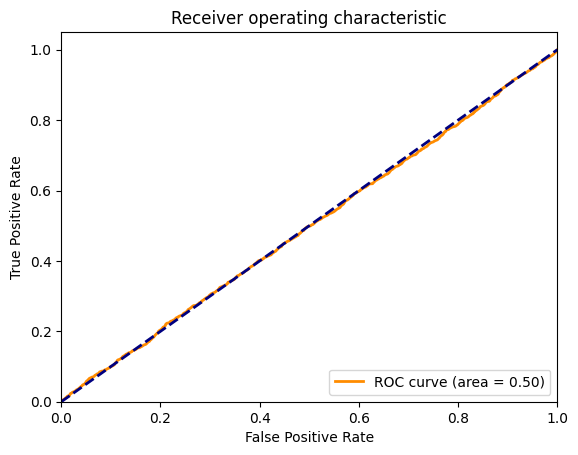

In [6]:
predictions = np.mean([pred[:, 1] for pred in test_callback.predictions], axis=0)
fpr, tpr, thresholds = roc_curve(Y_test[:, 1], predictions)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

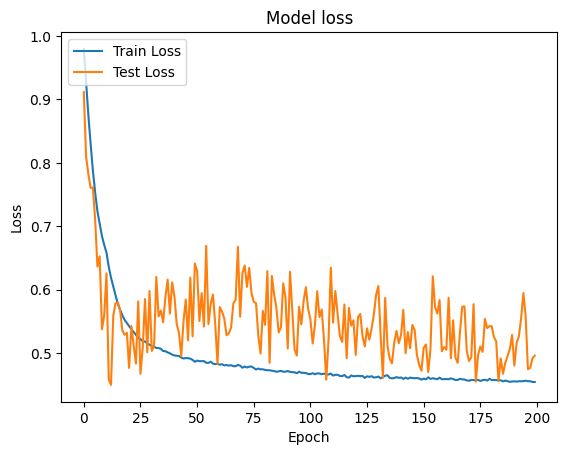

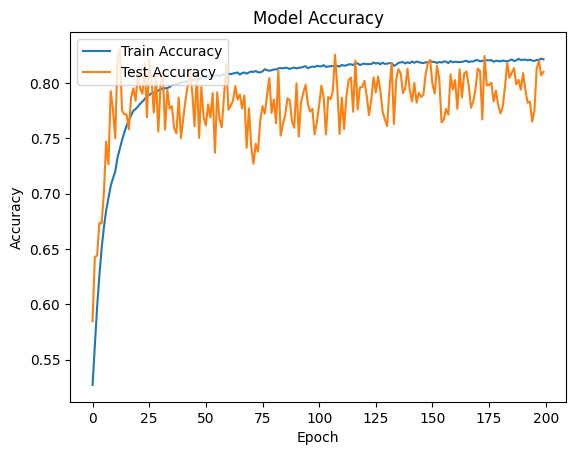

In [7]:
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(test_callback.test_loss, label='Test Loss')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

# Plot training & testing accuracy
plt.plot(history.history['pos_neg_acc'], label='Train Accuracy')
plt.plot(test_callback.test_acc, label='Test Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()